<a href="https://colab.research.google.com/github/SamoaChen/Frequentist-ML/blob/main/Market_Basket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASSIGNMENT TEXT

Select a dataset of interest to you and perform a market basket analysis, including finding frequent itemsets and mining association rules. Do not use a shopping cart dataset - select(or create) another kind of dataset and think of how to frame it as a market basket problem. You can use whatever implemtation of the A Priori algorithm you want, from the book, from here: http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/, or anything else you find.

This assignment is a little more subjective than previous assignments. Before starting, discuss your dataset with me. You will be graded on the quality of your explanation as well as the code. There are no performance goals to meet as this is a data mining project, but the model does need to be carefuly tuned to select frequent itemsets and association rules with high support, confidence and lift.  Your write-up should discuss what dataset you chose and why, what parameters you selected and why, give examples of itemsets and rules. You should wrap it up with a conclusion about what you 'discovered' about this dataset using this method.

# ABOUT OUR DATASET

In this notebook, we rely on a combination of two datasets that use the same format. The first is the [UCI Zoo dataset](https://archive.ics.uci.edu/ml/datasets/Zoo) and the second is the [Zoo Animals Extended dataset](https://www.kaggle.com/agajorte/zoo-animals-extended-dataset) from Kaggle.

The dataset is essentially a bunch of booleans, with some numeric values that we one-hot encode, that list out a bunch of animals and say what biological characteristics they have.

The format of the columns is as follows, taken from the UCI page:

```
1. animal name: Unique for each instance
2. hair: Boolean
3. feathers: Boolean
4. eggs: Boolean
5. milk: Boolean
6. airborne: Boolean
7. aquatic: Boolean
8. predator: Boolean
9. toothed: Boolean
10. backbone: Boolean
11. breathes: Boolean
12. venomous: Boolean
13. fins: Boolean
14. legs: Numeric (set of values: {0,2,4,5,6,8})
15. tail: Boolean
16. domestic: Boolean
17. catsize: Boolean
18. type: Numeric (integer values in range [1,7])
```


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data

# put kaggle.json in the session folder with API key before running
!chmod 600 /root/.kaggle/kaggle.json
!mv "kaggle.json" /root/.kaggle
!kaggle datasets download "agajorte/zoo-animals-extended-dataset"
!unzip "zoo-animals-extended-dataset.zip"

!pip install mlxtend

from IPython.display import display as disp
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

--2020-11-16 00:41:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4126 (4.0K) [application/x-httpd-php]
Saving to: ‘zoo.data.1’

zoo.data.1          100%[===================>]   4.03K  --.-KB/s    in 0s      

2020-11-16 00:41:23 (85.8 MB/s) - ‘zoo.data.1’ saved [4126/4126]

mv: cannot stat 'kaggle.json': No such file or directory
zoo-animals-extended-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  zoo-animals-extended-dataset.zip
replace zoo2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
zoo_cols = ['animal_name','hair','feathers', 'eggs', 'milk','airborne', 'aquatic','predator','toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs','tail', 'domestic','catsize','class_type']
df_zoo = pd.DataFrame(columns=zoo_cols)

data1 = 'zoo.data'
df_zoo1 = pd.read_csv(data1, sep=',', header=None, names=zoo_cols)
df_zoo1

data2 = 'zoo2.csv'
df_zoo2 = pd.read_csv(data2)
df_zoo2

data3 = 'zoo3.csv'
df_zoo3 = pd.read_csv(data3)
df_zoo3

#CONCATENATING DATA FRAMES
df_zoo = pd.concat([df_zoo1, df_zoo2, df_zoo3])

disp(df_zoo)

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,vespa,0,0,1,0,1,0,1,0,0,1,1,0,6,0,0,0,6
66,bicho-pau,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0,7
67,caracol-da-mata-atlantica,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7
68,caranguejeira,1,0,1,0,0,0,1,0,0,1,1,0,8,0,0,0,7


Three data set with the same format are combined with each other, resulting in a more balanced species number

<p float="left">
   <img src="https://res.cloudinary.com/dk-find-out/image/upload/q_80,w_1920,f_auto/DCTM_Penguin_UK_DK_AL456629_eguu4l.jpg" width="45%" height="45%">
   <img src="https://images.immediate.co.uk/production/volatile/sites/4/2009/07/GettyImages-931270318-43ab672.jpg?quality=90&resize=940%2C400" width="45%" height="45%">
   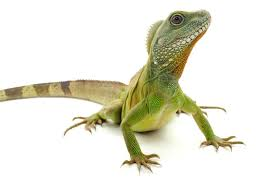
   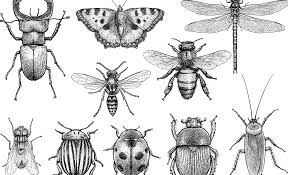
   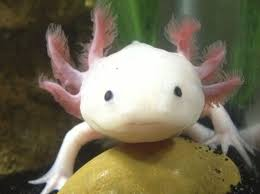
   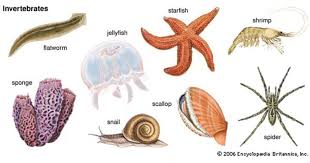
   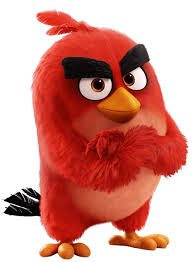
</p>

In [ ]:
# Get number of different class types
categories = ['mammal', 'bird', 'reptile', 'fish', 'amphibian', 'insect', 'invertebrate']

for class_num in range(1, len(df_zoo.class_type.unique())+1):
  print("Count of {}: {}".format(categories[class_num-1], len(df_zoo[df_zoo.class_type == class_num])))

Count of mammal: 60
Count of bird: 40
Count of reptile: 25
Count of fish: 28
Count of amphibian: 16
Count of insect: 25
Count of invertebrate: 20


In [ ]:
#---------------CREATE ONE-HOT-ENCODED VARIABLES FOR DIFFERENT CATEGORIES
for idx, category in enumerate(categories):
  df_zoo.loc[df_zoo['class_type'] != idx+1 , category] = 0
  df_zoo.loc[df_zoo['class_type'] == idx+1 , category] = 1

#---------------CREATE ONE-HOT-ENCODED VARIABLES FOR DIFFERENT LEG NUMBER

for idx, leg_type in enumerate(['no_legs', '2_legs', '4_legs', '6_legs']):
  df_zoo.loc[df_zoo['legs'] != 2*idx , leg_type] = 0
  df_zoo.loc[df_zoo['legs'] == 2*idx , leg_type] = 1

df_zoo = df_zoo.drop(columns=['class_type', 'legs', 'animal_name'])
zoo_analysis = df_zoo.astype('bool')

disp(zoo_analysis)


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,tail,domestic,catsize,mammal,bird,reptile,fish,amphibian,insect,invertebrate,no_legs,2_legs,4_legs,6_legs
0,True,False,False,True,False,False,True,True,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False
1,True,False,False,True,False,False,False,True,True,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False
2,False,False,True,False,False,True,True,True,True,False,False,True,True,False,False,False,False,False,True,False,False,False,True,False,False,False
3,True,False,False,True,False,False,True,True,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False
4,True,False,False,True,False,False,True,True,True,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,False,False,True,False,True,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
66,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
67,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
68,True,False,True,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


breathes        176
backbone        169
eggs            153
tail            145
toothed         114
predator        100
catsize          82
aquatic          79
4_legs           78
hair             66
mammal           60
milk             60
no_legs          53
airborne         53
2_legs           49
bird             40
feathers         40
fins             35
6_legs           29
domestic         28
fish             28
reptile          25
insect           25
venomous         23
invertebrate     20
amphibian        16
dtype: int64

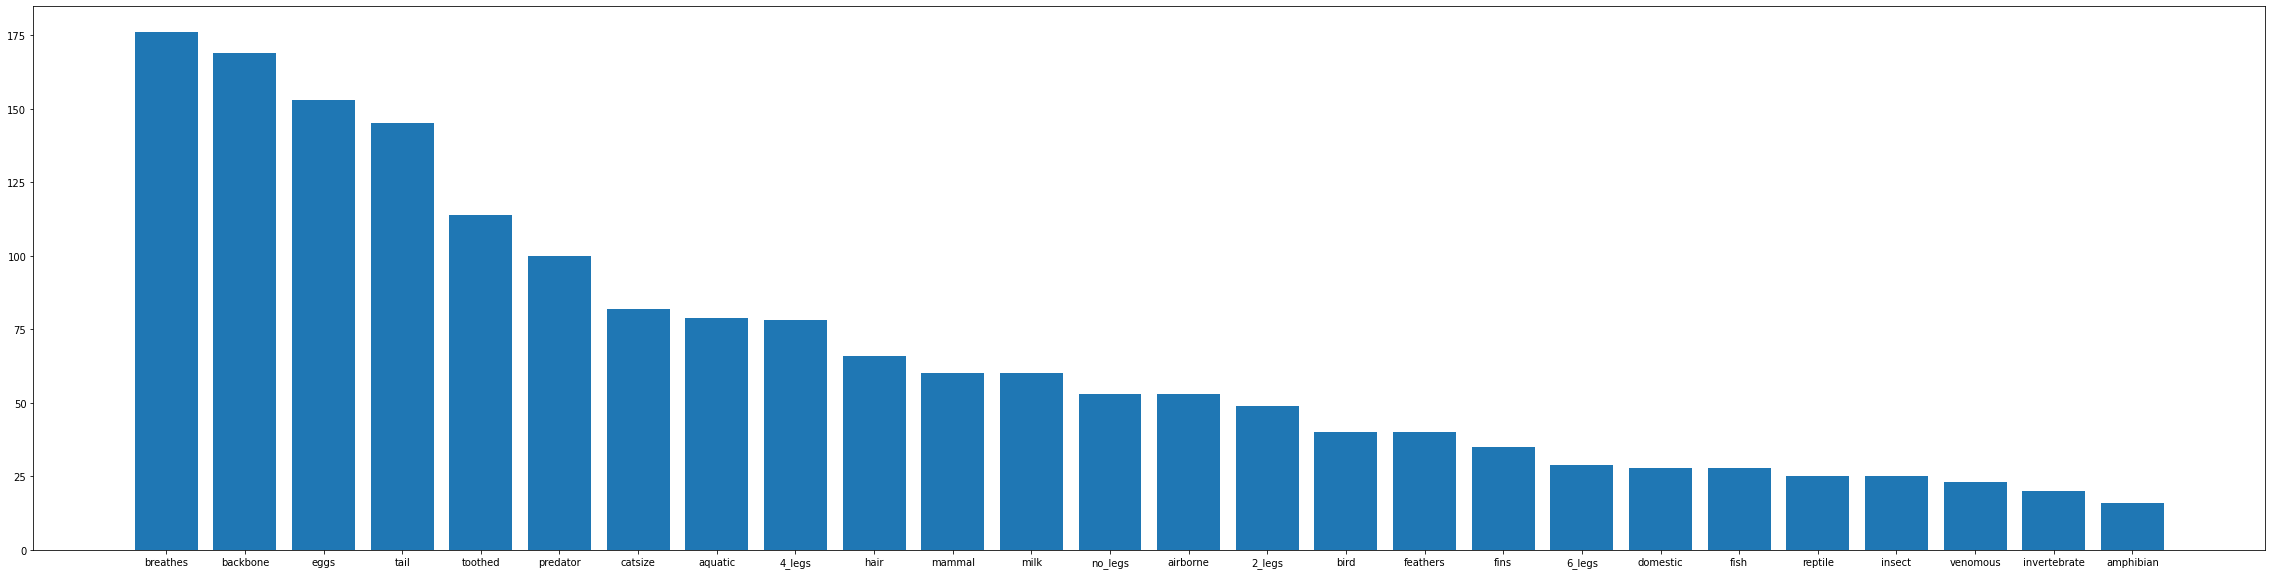

In [ ]:
# Plot the frequency of each feature
hist_data = zoo_analysis.sum().sort_values(ascending = False)
disp(hist_data)
plt.figure(figsize=(40,10))
fig = plt.bar(x = hist_data.index, height = hist_data)


It is shown on the bar chart, the most frequent characteristic is breathes, followed by backbone, eggs, and tail. In this data set the animal categories are not evenly distributed. The most frequent animal category is mammal, followed by bird and fish.

Note that the lowest support value, 0.070093, corresponds to 1/15. By setting our min_support value to 0.07, we capture only itemsets that occur in at least 1/15 of the animals in our zoo dataset.

To include features from the smallest animal category, amphibian, the minimum support is set to 7%. (Amphibians make up 16/214 samples, or about 7.5%, of the dataset.)

In [ ]:
zoo_analysis.amphibian.value_counts()

False    198
True      16
Name: amphibian, dtype: int64

In [ ]:
#------------FINDING FREQUENT ITEM SETS
frequent_itemsets = apriori(zoo_analysis, min_support=0.07, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.sort_values(by=['support'],ascending=False, inplace=True)
disp(frequent_itemsets)

,support,itemsets,length
9,0.822430,(breathes),1
8,0.789720,(backbone),1
2,0.714953,(eggs),1
12,0.677570,(tail),1
119,0.672897,"(tail, backbone)",2
...,...,...,...
1371,0.070093,"(tail, predator, eggs, bird, breathes)",5
1370,0.070093,"(predator, backbone, eggs, bird, 2_legs)",5
1369,0.070093,"(tail, predator, backbone, eggs, 2_legs)",5
1366,0.070093,"(tail, predator, backbone, eggs, bird)",5


In [ ]:
#------------FREQUENT ITEM SET WITH CERTAIN ITEM NUMBER
disp(frequent_itemsets[ (frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.5) ])

,support,itemsets,length
119,0.672897,"(tail, backbone)",2
117,0.658879,"(breathes, backbone)",2
131,0.546729,"(breathes, tail)",2
49,0.542056,"(breathes, eggs)",2
106,0.528037,"(backbone, toothed)",2
48,0.509346,"(eggs, backbone)",2


The itemsets with support higher than 50% and two item number are included above. The result demonstrate that tooth and backbone come together very often, and back bone and tail also come together.This is reasonable because backbone and tooth are composed of same material. 

In [ ]:
#------------FREQUENT ITEM SET WITH CERTAIN ITEM NUMBER
frequent_itemsets[ (frequent_itemsets['length'] == 3) &
                   (frequent_itemsets['support'] >= 0.5) ]

,support,itemsets,length
470,0.542056,"(breathes, tail, backbone)",3


Backbone, breathes, and tail are assigned together as frequent itemset with a support higher than 50%. 

In [ ]:
#------------FREQUENT ITEMSET WITH CERTAIN ITEMS
frequent_itemsets[ frequent_itemsets['itemsets'] == {'backbone','amphibian'} ]

,support,itemsets,length
126,0.074766,"(amphibian, backbone)",2


The set above is printed to demonstrate that information for amphibian is included in the analysis

In [ ]:
#------------ASSOCIATION RULES MINING
#NARROW DOWN FREQUENT ITEMSETS
two_items_sets = frequent_itemsets[ (frequent_itemsets['length'] <= 2) ]

rules_set = association_rules(two_items_sets, metric="confidence", min_threshold=1)
disp(rules_set.sort_values(by=['confidence'],ascending=False))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(hair),(breathes),0.308411,0.822430,0.308411,1.0,1.215909,0.054765,inf
19,(bird),(2_legs),0.186916,0.228972,0.186916,1.0,4.367347,0.144117,inf
21,(fins),(aquatic),0.163551,0.369159,0.163551,1.0,2.708861,0.103175,inf
22,(6_legs),(eggs),0.135514,0.714953,0.135514,1.0,1.398693,0.038628,inf
23,(fish),(backbone),0.130841,0.789720,0.130841,1.0,1.266272,0.027513,inf
24,(fish),(fins),0.130841,0.163551,0.130841,1.0,6.114286,0.109442,inf
25,(fish),(no_legs),0.130841,0.247664,0.130841,1.0,4.037736,0.098437,inf
26,(fish),(eggs),0.130841,0.714953,0.130841,1.0,1.398693,0.037296,inf
27,(fish),(aquatic),0.130841,0.369159,0.130841,1.0,2.708861,0.082540,inf
28,(fish),(tail),0.130841,0.677570,0.130841,1.0,1.475862,0.042187,inf


From the association anaylysis, we can draw out many intuitive result. e.g bird lead to feathers, insect lead to 6 legs, and fish lead to aquatic.

#Analysis with equal class type numbers

In [ ]:
#EDITING THE DATA SET TO EQUALIZE ALL CLASS TYPE NUMBER

NUM_SAMPLES_PER_CATEGORY = 16
RANDOM_STATE = 42

zoo_analysis_new = pd.DataFrame(columns=zoo_analysis.columns.values)
for category in categories:
  zoo_analysis_new = zoo_analysis_new.append(zoo_analysis[zoo_analysis[category] == 1].sample(n=NUM_SAMPLES_PER_CATEGORY, random_state=RANDOM_STATE))

disp(zoo_analysis_new)

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,tail,domestic,catsize,mammal,bird,reptile,fish,amphibian,insect,invertebrate,no_legs,2_legs,4_legs,6_legs
0,True,False,False,True,False,False,True,True,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False
6,True,False,False,True,False,False,False,True,True,True,False,False,True,True,True,True,False,False,False,False,False,False,False,False,True,False
84,True,False,False,True,False,False,False,True,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False
4,True,False,False,True,False,False,True,True,True,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False
29,True,False,False,True,False,False,True,True,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
99,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
69,True,False,True,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
53,False,False,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False


In order to output frequent item set and association rule that can predict animal categories, same number of different animal categores are drawn randomly from each category.

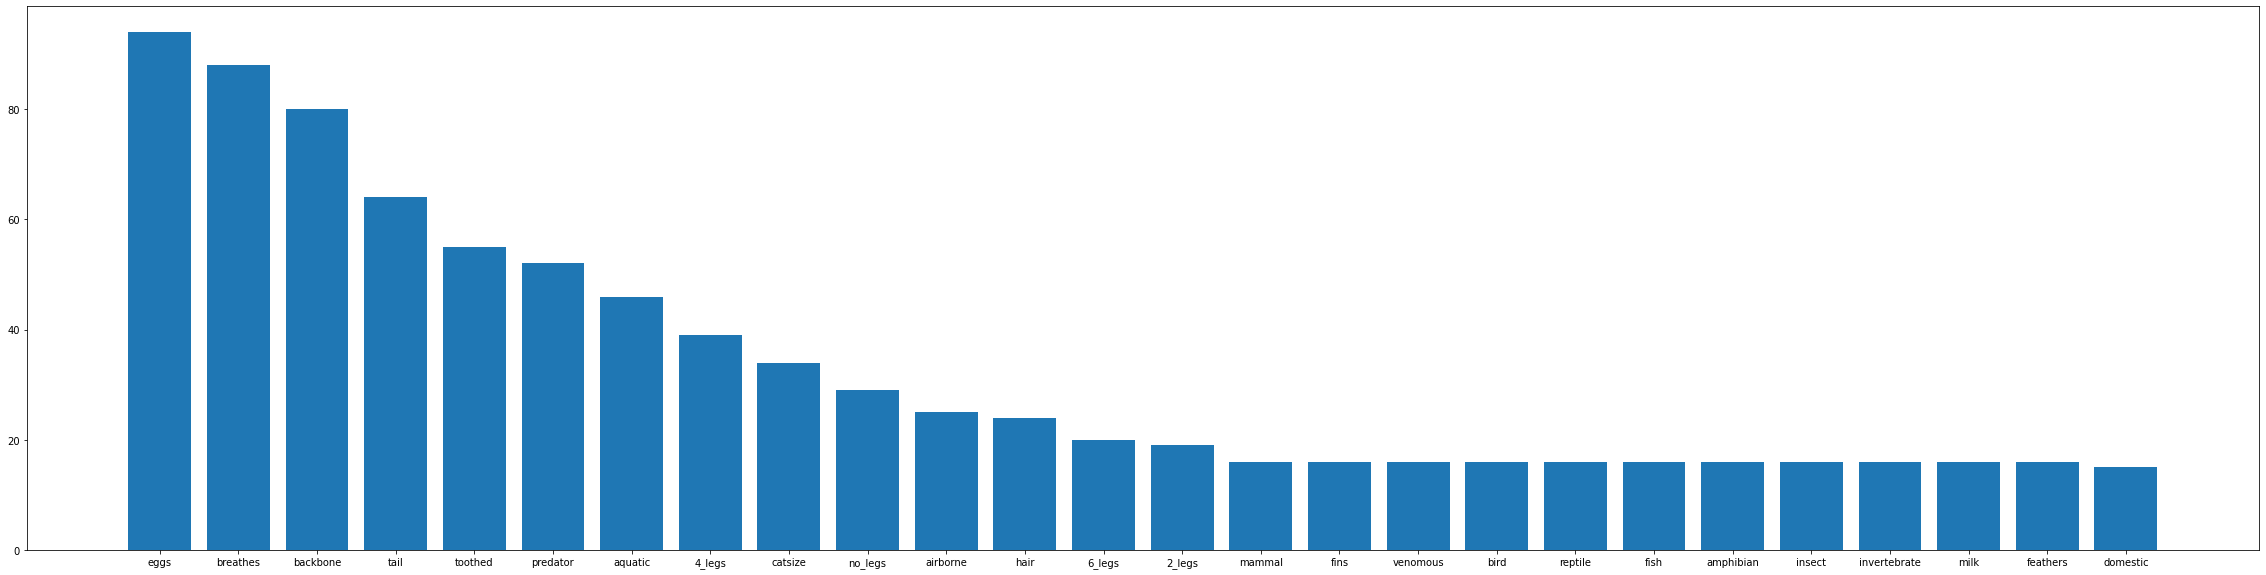

In [ ]:
#DATA VISUALIZATION
hist_data = zoo_analysis_new.sum().sort_values(ascending = False)
hist_data
plt.figure(figsize=(40,10))
fig = plt.bar(x = hist_data.index, height = hist_data)

In [ ]:
#------------FINDING FREQUENT ITEM SETS
frequent_itemsets = apriori(zoo_analysis_new, min_support=0.14, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.sort_values(by=['support'],ascending=False)
frequent_itemsets

,support,itemsets,length
0,0.214286,(hair),1
1,0.142857,(feathers),1
2,0.839286,(eggs),1
3,0.142857,(milk),1
4,0.223214,(airborne),1
...,...,...,...
420,0.142857,"(tail, backbone, aquatic, eggs, fish, no_legs)",6
421,0.142857,"(tail, aquatic, eggs, fins, fish, no_legs)",6
422,0.142857,"(tail, backbone, eggs, fins, fish, no_legs)",6
423,0.142857,"(tail, backbone, aquatic, fins, fish, no_legs)",6


In [ ]:
#------------FREQUENT ITEM SET WITH CERTAIN ITEM NUMBER
frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.5) ]

,support,itemsets,length
39,0.5625,"(eggs, backbone)",2
40,0.633929,"(breathes, eggs)",2
81,0.5625,"(breathes, backbone)",2
83,0.5625,"(tail, backbone)",2


The frequent itemsets with 2 items and a support higher than 50% for this dataframe matches with the result from the previous result of dataframe

In [ ]:
categories

['mammal', 'bird', 'reptile', 'fish', 'amphibian', 'insect', 'invertebrate']

In [ ]:
#------------ASSOCIATION RULES MINING
#NARROW DOWN FREQUENT ITEMSETS
two_items_sets = frequent_itemsets[ (frequent_itemsets['length'] <= 5) ]

rules_set = association_rules(two_items_sets, metric="confidence", min_threshold=1)
rules_set.sort_values(by=['confidence'],ascending=False)

rules_set['length_conse'] = rules_set['consequents'].apply(lambda x: len(x))
rules_set['length_ante'] = rules_set['antecedents'].apply(lambda x: len(x))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(milk),(hair),0.142857,0.214286,0.142857,1.0,4.666667,0.112245,inf
1065,"(breathes, 2_legs, feathers)","(eggs, backbone)",0.142857,0.562500,0.142857,1.0,1.777778,0.062500,inf
1075,"(eggs, bird, 2_legs, feathers)",(backbone),0.142857,0.714286,0.142857,1.0,1.400000,0.040816,inf
1074,"(bird, 2_legs, backbone, feathers)",(eggs),0.142857,0.839286,0.142857,1.0,1.191489,0.022959,inf
1073,"(eggs, 2_legs, backbone, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.000000,0.122449,inf
...,...,...,...,...,...,...,...,...,...
531,"(amphibian, aquatic)","(breathes, eggs)",0.142857,0.633929,0.142857,1.0,1.577465,0.052296,inf
530,"(amphibian, eggs)","(breathes, aquatic)",0.142857,0.205357,0.142857,1.0,4.869565,0.113520,inf
529,"(breathes, amphibian)","(eggs, aquatic)",0.142857,0.401786,0.142857,1.0,2.488889,0.085459,inf
528,"(amphibian, eggs, aquatic)",(breathes),0.142857,0.785714,0.142857,1.0,1.272727,0.030612,inf


In [ ]:
def show_consequents_and_antecedents(category):
  print("{} as consequent".format(category))
  disp(rules_set[ (rules_set['consequents'] == {category})].sort_values(by=["length_ante"], ascending=True))
  print("{} as antecedent".format(category))
  disp(rules_set[ (rules_set['antecedents'] == {category})].sort_values(by=["length_conse"], ascending=True))
  print("\n\n")

Based on the given dataset, if an animal produce milk, than it can be categorized as mammal. Similarly if hair and backbone is observed, than the animal can be categorized as mammal etc.

Similarly, if we know a type of animal is mammal, the above characteristics in the consequents can be concluded based on the given dataset 

In [ ]:
show_consequents_and_antecedents("mammal")

mammal as consequent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante
19,(milk),(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,1
57,"(hair, milk)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
66,"(hair, toothed)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
70,"(hair, backbone)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
183,"(milk, toothed)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
191,"(backbone, milk)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
196,"(breathes, milk)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
729,"(breathes, backbone, milk)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,3
718,"(breathes, milk, toothed)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,3
707,"(backbone, milk, toothed)",(mammal),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,3


mammal as antecedent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante
2,(mammal),(hair),0.142857,0.214286,0.142857,1.0,4.666667,0.112245,inf,1,1
20,(mammal),(milk),0.142857,0.142857,0.142857,1.0,7.000000,0.122449,inf,1,1
25,(mammal),(toothed),0.142857,0.491071,0.142857,1.0,2.036364,0.072704,inf,1,1
27,(mammal),(backbone),0.142857,0.714286,0.142857,1.0,1.400000,0.040816,inf,1,1
33,(mammal),(breathes),0.142857,0.785714,0.142857,1.0,1.272727,0.030612,inf,1,1
242,(mammal),"(breathes, toothed)",0.142857,0.366071,0.142857,1.0,2.731707,0.090561,inf,2,1
237,(mammal),"(backbone, toothed)",0.142857,0.482143,0.142857,1.0,2.074074,0.073980,inf,2,1
200,(mammal),"(breathes, milk)",0.142857,0.142857,0.142857,1.0,7.000000,0.122449,inf,2,1
195,(mammal),"(backbone, milk)",0.142857,0.142857,0.142857,1.0,7.000000,0.122449,inf,2,1
248,(mammal),"(breathes, backbone)",0.142857,0.562500,0.142857,1.0,1.777778,0.062500,inf,2,1


Running the same analysis on birds also shows us what qualities are essential to birdness: feathers, eggs, breathing, two-leggedness, and a backbone.

In [ ]:
show_consequents_and_antecedents("bird")

bird as consequent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante
7,(feathers),(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,1
85,"(eggs, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
96,"(backbone, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
104,"(breathes, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
112,"(2_legs, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,2
414,"(eggs, backbone, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,3
433,"(breathes, feathers, eggs)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,3
451,"(eggs, 2_legs, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,3
461,"(breathes, backbone, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,3
480,"(2_legs, backbone, feathers)",(bird),0.142857,0.142857,0.142857,1.0,7.0,0.122449,inf,1,3


bird as antecedent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante
6,(bird),(feathers),0.142857,0.142857,0.142857,1.0,7.000000,0.122449,inf,1,1
11,(bird),(eggs),0.142857,0.839286,0.142857,1.0,1.191489,0.022959,inf,1,1
28,(bird),(backbone),0.142857,0.714286,0.142857,1.0,1.400000,0.040816,inf,1,1
34,(bird),(breathes),0.142857,0.785714,0.142857,1.0,1.272727,0.030612,inf,1,1
43,(bird),(2_legs),0.142857,0.169643,0.142857,1.0,5.894737,0.118622,inf,1,1
281,(bird),"(2_legs, backbone)",0.142857,0.169643,0.142857,1.0,5.894737,0.118622,inf,2,1
251,(bird),"(breathes, backbone)",0.142857,0.562500,0.142857,1.0,1.777778,0.062500,inf,2,1
170,(bird),"(eggs, 2_legs)",0.142857,0.151786,0.142857,1.0,6.588235,0.121173,inf,2,1
145,(bird),"(breathes, eggs)",0.142857,0.633929,0.142857,1.0,1.577465,0.052296,inf,2,1
289,(bird),"(breathes, 2_legs)",0.142857,0.169643,0.142857,1.0,5.894737,0.118622,inf,2,1


We can see that given the information that an animal is a reptile, it definitely has a backbone, but the reverse is not true: there is no combination of features in this set that let us say with certain that an animal is actually a reptile.

In [ ]:
show_consequents_and_antecedents("reptile")

reptile as consequent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante


reptile as antecedent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante
29,(reptile),(backbone),0.142857,0.714286,0.142857,1.0,1.4,0.040816,inf,1,1


The same is true here; the list of consequents for amphibians is empty. However, we can see that given the information that a species is an amphibian, we know it has eggs, breathes, has a backbone, and is aquatic.

In [ ]:
show_consequents_and_antecedents("amphibian")

amphibian as consequent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante


amphibian as antecedent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante
13,(amphibian),(eggs),0.142857,0.839286,0.142857,1.0,1.191489,0.022959,inf,1,1
24,(amphibian),(aquatic),0.142857,0.410714,0.142857,1.0,2.434783,0.084184,inf,1,1
31,(amphibian),(backbone),0.142857,0.714286,0.142857,1.0,1.400000,0.040816,inf,1,1
35,(amphibian),(breathes),0.142857,0.785714,0.142857,1.0,1.272727,0.030612,inf,1,1
127,(amphibian),"(eggs, aquatic)",0.142857,0.401786,0.142857,1.0,2.488889,0.085459,inf,2,1
141,(amphibian),"(eggs, backbone)",0.142857,0.562500,0.142857,1.0,1.777778,0.062500,inf,2,1
148,(amphibian),"(breathes, eggs)",0.142857,0.633929,0.142857,1.0,1.577465,0.052296,inf,2,1
212,(amphibian),"(backbone, aquatic)",0.142857,0.357143,0.142857,1.0,2.800000,0.091837,inf,2,1
215,(amphibian),"(breathes, aquatic)",0.142857,0.205357,0.142857,1.0,4.869565,0.113520,inf,2,1
254,(amphibian),"(breathes, backbone)",0.142857,0.562500,0.142857,1.0,1.777778,0.062500,inf,2,1


Meanwhile with insects, we can see that knowing a species is an insect lets us conclude that it must breathe, have six legs (at least, from what we know in the dataset), and lay eggs.

In [ ]:
show_consequents_and_antecedents("insect")

insect as consequent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante


insect as antecedent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante
14,(insect),(eggs),0.142857,0.839286,0.142857,1.0,1.191489,0.022959,inf,1,1
36,(insect),(breathes),0.142857,0.785714,0.142857,1.0,1.272727,0.030612,inf,1,1
45,(insect),(6_legs),0.142857,0.178571,0.142857,1.0,5.600000,0.117347,inf,1,1
151,(insect),"(breathes, eggs)",0.142857,0.633929,0.142857,1.0,1.577465,0.052296,inf,2,1
176,(insect),"(eggs, 6_legs)",0.142857,0.178571,0.142857,1.0,5.600000,0.117347,inf,2,1
292,(insect),"(breathes, 6_legs)",0.142857,0.160714,0.142857,1.0,6.222222,0.119898,inf,2,1
663,(insect),"(breathes, 6_legs, eggs)",0.142857,0.160714,0.142857,1.0,6.222222,0.119898,inf,3,1


Interestingly, we cannot see any new information from knowing that a species is an invertebrate; within the dataset, there is so much diversity in the invertebrates that no one feature or set of features is common to all of them. This means there are neither antecedents nor consequents for invertebrates.

In [ ]:
show_consequents_and_antecedents("invertebrate")

invertebrate as consequent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante


invertebrate as antecedent


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length_conse,length_ante


In summary, we observed that for animals in general, backbone comes together with tail. From association rules mining, we can conclude that if milk is observe or a combination of hair and backbone or breathe is observed, than we can conclude the animal's category as mammal. If feathers is observed, we can conclude the animal's category as bird. The categorizing features for retile, amphibian, and invertebrate are ambiguous, thus can not be identified clearly.

These are tautologically true. For instance, hair and milk are definitionally part of what it means to be a mammal. But that's the point of our analysis. What we have done with this dataset is look for features that let us say with certainty what category an animal belongs to, and our rule-set essentially reverse engineers the definition of each category by using a 100% confidence metric.

Another way that we could look at this dataset, if we wanted to answer a different question, is to reduce the required confidence level so that we get partial matches, and try to look for common sets of rules between types of animals. This would let us determine which groups of animals might be closer to some than to others.

